https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [1]:
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('hmnist_28_28_RGB.csv')

In [4]:
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [5]:
df['label'].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [6]:
np.array(df.drop(['label'],axis=1)).shape

(10015, 2352)

In [7]:
imgs = np.array(df.drop(['label'],axis=1)).reshape(10015,28,28,3)

In [8]:
img = imgs[0]

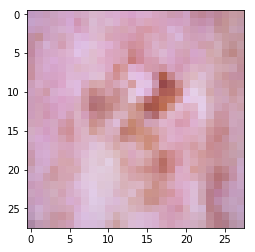

In [9]:
plt.imshow(img)

In [10]:
X = np.array(df.drop(['label'],axis=1)).reshape(10015,28,28,3)
y = np.array(df['label'])

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape

(8012, 28, 28, 3)

In [14]:
X_test.shape

(2003, 28, 28, 3)

In [15]:
import torch
import torch.nn as nn

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 28*28*3)
y_train = torch.tensor(y_train, dtype=torch.long).view(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 28*28*3)
y_test = torch.tensor(y_test, dtype=torch.long).view(-1)

In [17]:
X_train.shape, y_train.shape

(torch.Size([8012, 2352]), torch.Size([8012]))

In [18]:
28*28*3

2352

In [30]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28*3, 256)
        #self.fc2 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        #self.fc4 = nn.Linear(64, 7)
        
#         self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
#         x = self.dropout(x)
        x = self.relu(self.fc2(x))
#         x = self.dropout(x)
        #x = self.relu(self.fc3(x))
#         x = self.dropout(x)
       # x = self.relu(self.fc4(x))
        x = self.fc3(x)        
       
        return x

In [31]:
model = Net()

In [32]:
model

Net(
  (fc1): Linear(in_features=2352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (relu): ReLU()
)

In [33]:
def get_batch_index(m, b): 
    indexes = np.random.permutation(torch.arange(m))    
    for i in range(0, m, b):
        yield indexes[i:i+b]

In [34]:
learning_rate = 0.0001
epochs = 15
batch_size = 32
m = X_train.shape[0]
test_size = X_test.shape[0]

crossentropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                            weight_decay=0.01)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    
    for batch_i in get_batch_index(m, batch_size):
        X_batch = X_train[batch_i] 
        y_batch = y_train[batch_i] 
        
        model.train()
        
        optimizer.zero_grad()

        out = model(X_batch)
        
        loss = crossentropy(out, y_batch)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        predictions = torch.argmax(out, 1) 
        epoch_acc += torch.sum(predictions == y_batch).item()
    test_loss = 0
    test_acc = 0
    for batch_i in range(0, test_size, batch_size):
        X_batch = X_test[batch_i:batch_i+batch_size]
        y_batch = y_test[batch_i:batch_i+batch_size]
        
        model.eval()

        out = model(X_batch)

        loss = crossentropy(out, y_batch)
        test_loss += loss.item()
        predictions = torch.argmax(out, 1)
        test_acc += torch.sum(predictions == y_batch).item()


    print(f"Epoch {epoch}:")
    print("Train Loss:", epoch_loss/(m//batch_size), "Train Acc:", epoch_acc/m)
    print("Test Loss:", test_loss/(test_size//batch_size), "Test Acc:", test_acc/test_size)   
    print("="*20)

Epoch 0:
Train Loss: 2.2309031448364256 Train Acc: 0.5961058412381428
Test Loss: 1.3617174173555067 Test Acc: 0.5776335496754867
Epoch 1:
Train Loss: 1.507511253595352 Train Acc: 0.6157014478282576
Test Loss: 1.2987829408337992 Test Acc: 0.562656015976036
Epoch 2:
Train Loss: 1.31603686773777 Train Acc: 0.6342985521717424
Test Loss: 1.58823827966567 Test Acc: 0.6699950074887668
Epoch 3:
Train Loss: 1.215627347111702 Train Acc: 0.6451572641038442
Test Loss: 1.2083804991937452 Test Acc: 0.63554667998003
Epoch 4:
Train Loss: 1.1239262949228286 Train Acc: 0.6440339490763854
Test Loss: 1.0528424103413858 Test Acc: 0.6704942586120819
Epoch 5:
Train Loss: 1.0450872381925582 Train Acc: 0.6553919121318023
Test Loss: 1.4195650258371908 Test Acc: 0.6684972541188218
Epoch 6:
Train Loss: 1.0325249955654143 Train Acc: 0.6565152271592611
Test Loss: 0.9947532819163415 Test Acc: 0.6824762855716425
Epoch 7:
Train Loss: 0.9835953495502472 Train Acc: 0.6677483774338492
Test Loss: 0.9247660531151679 Test A